# GNN 


Code based on 

https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=zF5bw3m9UrMy

In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
import random
from math import floor
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import time
import numpy as np



c:\Users\markm\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import data
X = pd.read_csv('./Data/df_X_gnn.csv')
y = pd.read_csv('./Data/df_y_gnn.csv')
edge_idx = np.genfromtxt('./Data/df_e_idx_gnn.csv', delimiter=',')


edge_att = pd.read_csv('./Data/df_e_att_gnn.csv')

X = X.to_numpy()
y = y.to_numpy()
y = y[:,0]



X = torch.tensor(X).float()
y = torch.tensor(y).float()
edge_idx = torch.tensor(edge_idx).int()
edge_att = torch.tensor(edge_att.to_numpy()).float()

#edge_idx = edge_idx.transpose(0,1)

edge_idx.size()

torch.Size([2, 36])

In [3]:
# make masks
n = X.shape[0]
randomassort = list(range(n))
random.shuffle(randomassort)

# percentage of training mask
train_perc = 0.2
max_train = floor(len(randomassort) * train_perc)
train_mask_idx = torch.tensor(randomassort[:max_train])
test_mask_idx = torch.tensor(randomassort[max_train:])
train_mask = torch.zeros(n); test_mask = torch.zeros(n)
train_mask.scatter_(0, train_mask_idx, 1)
test_mask.scatter_(0, test_mask_idx, 1)
train_mask = train_mask.type(torch.bool)
test_mask = test_mask.type(torch.bool)
#train_mask

In [4]:
data = Data(x = X, y = y, edge_index = edge_idx)#, edge_attr = edge_att)

data.test_mask = test_mask
data.train_mask = train_mask
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')

Data(x=[10, 10], edge_index=[2, 36], y=[10], test_mask=[10], train_mask=[10])
Number of nodes: 10
Number of edges: 36
Average node degree: 3.60
Number of training nodes: 2
Training node label rate: 0.20
Has isolated nodes: False


In [5]:
data.x

tensor([[5.6059e+04, 4.1172e+04, 1.0060e+06, 3.5349e+05, 1.2653e+03, 1.4000e-01,
         2.1500e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [5.6059e+04, 4.1172e+04, 2.6226e+06, 9.4600e+05, 2.9936e+03, 1.4000e-01,
         2.1500e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [5.6059e+04, 4.1172e+04, 8.6169e+05, 3.0058e+05, 1.0318e+03, 1.4000e-01,
         2.1500e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [5.6059e+04, 4.1172e+04, 1.7948e+05, 5.9399e+04, 2.0567e+02, 1.0770e+01,
         2.5510e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [5.6059e+04, 4.1172e+04, 3.5046e+04, 1.2391e+04, 4.0032e+01, 1.0770e+01,
         2.5510e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [5.6059e+04, 4.1172e+04, 1.3353e+05, 4.9327e+04, 1.4530e+02, 1.0770e+01,
         2.5510e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [5.6059e+04, 4.1172e+04, 1.2979e+05, 3.9237e+04, 1.8611e+02, 1.0770e+01,
         2.5510e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [5.6059e+04, 4.1172

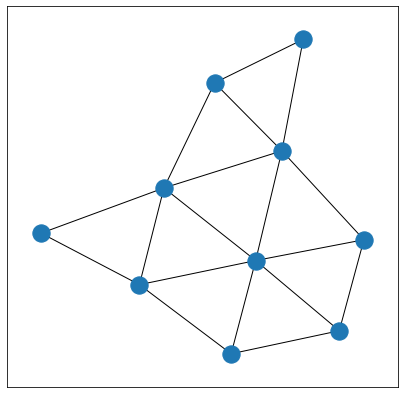

In [6]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, with_labels=False)#, pos=nx.spring_layout(G, seed=42)),
                     #node_color=color, cmap="Set2")
    plt.show()
    
    
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()


G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [7]:
# class GCN(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         torch.manual_seed(1234)
#         self.conv1 = GCNConv(data.num_features, 4)
#         self.conv2 = GCNConv(4, 4)
#         self.conv3 = GCNConv(4, 2)
#         self.pred = Linear(2, 1)

#     def forward(self, x, edge_index):
#         h = self.conv1(x, edge_index)
#         h = h.sigmoid()
#         h = self.conv2(h, edge_index)
#         h = h.sigmoid()
#         h = self.conv3(h, edge_index)
#         h = h.sigmoid()  # Final GNN embedding space.
        
#         # Apply a final (linear) classifier.
#         out = self.pred(h)

#         return out, h

# model = GCN()
# print(model)

In [8]:
# This one is for the small sample to avoid too many parameters
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(data.num_features, 4)
        self.conv3 = GCNConv(4, 2)
        self.pred = Linear(2, 1)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.pred(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(10, 4)
  (conv3): GCNConv(4, 2)
  (pred): Linear(in_features=2, out_features=1, bias=True)
)


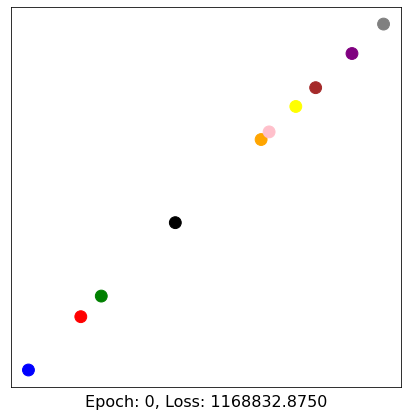

1168832.875


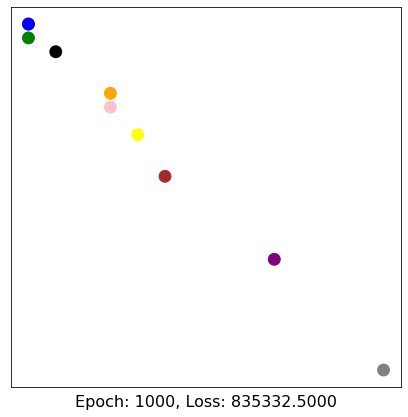

835332.5


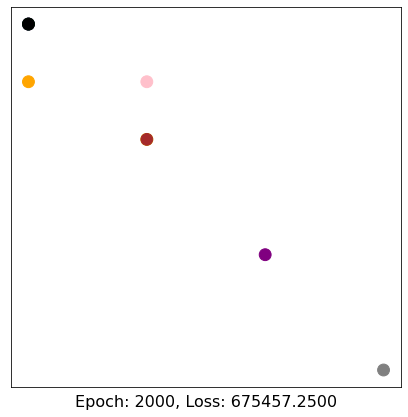

675457.25


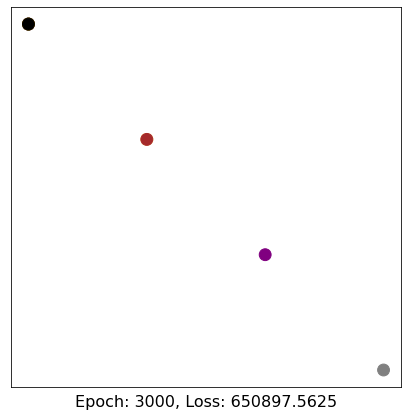

650897.5625


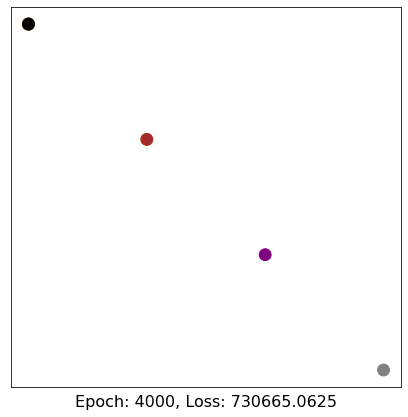

730665.0625


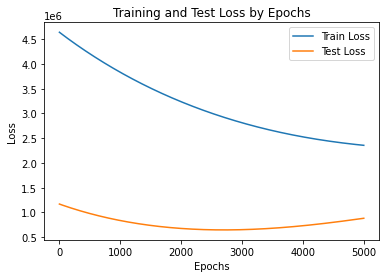

In [13]:

model = GCN()

criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Define optimizer.


def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    test_loss = criterion(out[data.test_mask], data.y[data.test_mask])  # Compute the loss for test nodes.
    train_loss.backward()  # Derive gradients. Only use train loss to update weights
    optimizer.step()  # Update parameters based on gradients.
    return train_loss, test_loss, h
colors = ["red", "blue", "green", "yellow", "purple", "orange", "pink", "brown", "black", "grey"]
train_loss_list = []
test_loss_list = []
for epoch in range(5000):
    
    train_loss, test_loss, h = train(data)
    train_loss_list.append(train_loss.item())
    test_loss_list.append(test_loss.item())
    if epoch % 1000 == 0:
        visualize_embedding(h, color=colors, epoch=epoch, loss=test_loss)
        print(test_loss.item())
        time.sleep(0.3)

def plot_loss(train_loss_list, test_loss_list):
    x_plt = range(len(train_loss_list))

    # Plot the training and test loss values
    plt.plot(x_plt, train_loss_list, label='Train Loss')
    plt.plot(x_plt, test_loss_list, label='Test Loss')

    # Set plot title and labels
    plt.title('Training and Test Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

plot_loss(train_loss_list, test_loss_list)